In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import cv2
import os
from os import listdir
import glob
import matplotlib.pyplot as plt
import seaborn as sns
# tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
import pathlib

data_dir = pathlib.Path("Resources/images/training")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['flip' 'notflip']


In [3]:
# let's visulaize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


def view_random_image(target_dir, target_class):
    
    target_folder =target_dir +target_class

  # get a random image path
    random_image =random.sample(os.listdir(target_folder),1)
  # read  in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" +random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")
    return img

Image shape: (1920, 1080, 3)


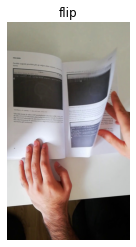

In [4]:
# View a random image from the training dataset
img =view_random_image(target_dir = "Resources/images/training/",
                       target_class = "flip")

Image shape: (1920, 1080, 3)


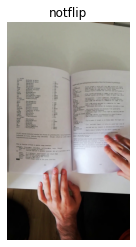

In [5]:
# View a random image from the training dataset
img =view_random_image(target_dir = "Resources/images/training/",
                       target_class = "notflip")

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)



# preprocess data(get all of the pixel values between 0 & 1 , also called normalization/scaling )
train_datagen  =ImageDataGenerator()
valid_datagen = ImageDataGenerator()

#setup path to our data directories
train_dir="Resources/images/training"
test_dir = "Resources/images/testing"

# import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               shuffle=False,
                                               batch_size=32,
                                               target_size = (150,150),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               shuffle=False,
                                               batch_size=32,
                                               target_size=(150,150),
                                               class_mode="binary",
                                               seed=42)   
'''
# resize images to 150x150:
size = (150, 150)

train_ds = train_dir.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = test_dir.map(lambda x, y: (tf.image.resize(x, size), y))

# batch the data and use caching & prefetching to optimize loading speed.
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
'''
#Using random data augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
) 

#Build a model
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)   

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
callback = tf.keras.callbacks.EarlyStopping()
epochs = 20
history=model.fit(train_data, epochs=epochs, validation_data=valid_data,callbacks=[callback])

Epoch 1/20
75/75 [==============================] - 127s 2s/step - loss: 0.6597 - binary_accuracy: 0.6120 - val_loss: 0.6283 - val_binary_accuracy: 0.7320
Epoch 2/20
75/75 [==============================] - 135s 2s/step - loss: 0.5737 - binary_accuracy: 0.6727 - val_loss: 0.5198 - val_binary_accuracy: 0.6147


In [24]:
model.evaluate(valid_data)

19/19 [==============================] - 21s 1s/step - loss: 0.5198 - binary_accuracy: 0.6147


[0.5197668671607971, 0.6147403717041016]

In [27]:
def plot_loss_curves(history):
    
    """
    Returns separte loss curves for training and validation metrics.
    """
    loss= history.history["loss"]
    val_loss =history.history["val_loss"]

    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]

    epochs =range(len(history.history["loss"]))

  # plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title('loss')
    plt.xlabel("epochs")
    plt.legend()

  # plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

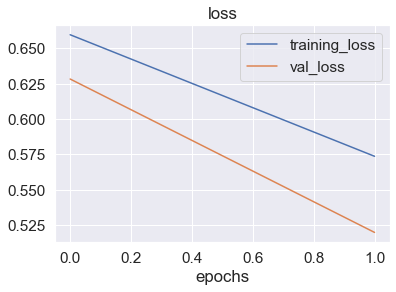

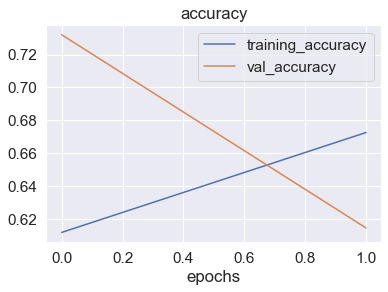

In [28]:
plot_loss_curves(history)

In [9]:
y_true = valid_data.classes
#y_true = y_true == 1
Y_pred = model.predict(valid_data, steps = len(valid_data))
y_pred = (Y_pred > 0.5).T[0]
y_pred_prob = Y_pred.T[0]

19/19 [==============================] - 35s 2s/step


In [10]:
cm = confusion_matrix(y_true, y_pred)
names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['flip', 'notflip']

Text(26.5, 0.5, 'Actual')

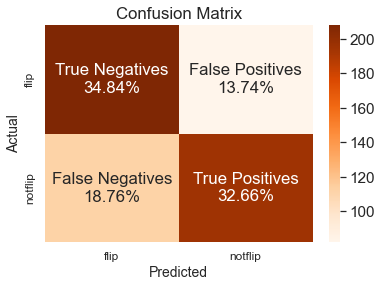

In [11]:
# Create confusion matrix as heatmap
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14) 

In [12]:
# create a function to import and image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=150):
    """
  Reads an image from filename, turns it into  a tensor and reshape it 
  to (img_shape, img_shape, color_Channel)
  """
  # read in the image
    img = tf.io.read_file(filename)
  # Decode the read file into a tensor
    img = tf.image.decode_image(img,channels=3)
  # resize the image
   # X_train = np.array(X_train).reshape(-1,150,150,1)
    img = tf.image.resize(img,(img_shape, img_shape))
  # rescale the image (get all value between 0 and 1)
    img = img/255.
    return img

In [13]:
def pred_and_plot(model, filename, class_names=class_names):
    
    
    """
  Imports an image located at filename, makes a prediction with model
  and plot the image with the predicted class as the title.
  """
  # import the target image and preprocess it
    img =load_and_prep_image(filename)

  # make a prediction
    pred= model.predict(tf.expand_dims(img, axis=0))

  # get the predicted class
    pred_class = class_names[int(tf.round(pred))]

  # plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 [==============================] - 1s 1s/step


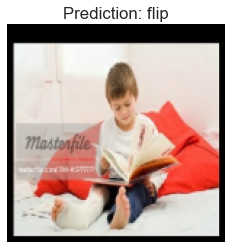

In [14]:
# test our model on a custom image
pred_and_plot(model, "Resources/test1.jpg")

1/1 [==============================] - 0s 114ms/step


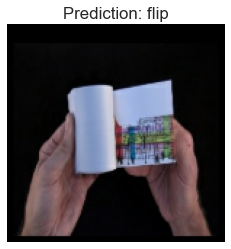

In [15]:
# test our model on a custom image
pred_and_plot(model, "Resources/test4.jpg")

1/1 [==============================] - 0s 122ms/step


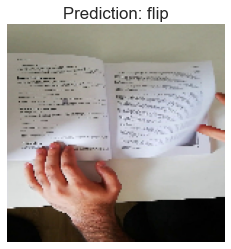

In [16]:
pred_and_plot(model, "Resources/flip (1).jpg")

1/1 [==============================] - 0s 117ms/step


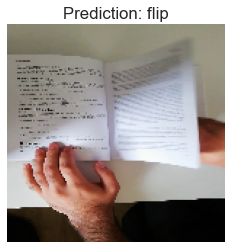

In [17]:
pred_and_plot(model, "Resources/flip (2).jpg")

1/1 [==============================] - 0s 107ms/step


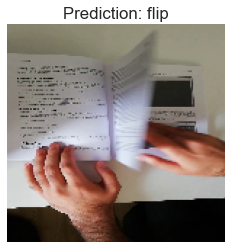

In [18]:
pred_and_plot(model, "Resources/flip (3).jpg")

1/1 [==============================] - 0s 74ms/step


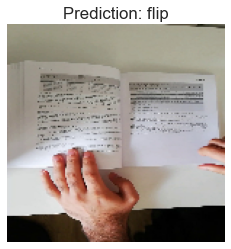

In [19]:
pred_and_plot(model, "Resources/notflip (1).jpg")

1/1 [==============================] - 0s 71ms/step


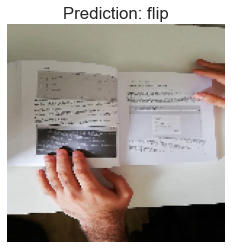

In [20]:
pred_and_plot(model, "Resources/notflip (3).jpg")

1/1 [==============================] - 0s 118ms/step


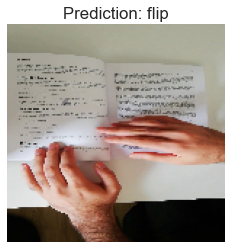

In [21]:
pred_and_plot(model, "Resources/notflip (2).jpg")